In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
data = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [60]:
data.head()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,0.344186,1,15,36,7,7
3/2/2019,0.534884,64,4,28,3,5
3/3/2019,0.037209,64,1,22,16,5
3/4/2019,0.539535,56,13,22,14,6
3/5/2019,0.000000,34,15,21,6,6


from matplotlib import pyplot as plt
_df_0['pm25'].plot(kind='hist', bins=20, title='pm25')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pm10'].plot(kind='hist', bins=20, title='pm10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['o3'].plot(kind='hist', bins=20, title='o3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['no2'].plot(kind='hist', bins=20, title='no2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='pm25', y='pm10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='pm10', y='o3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='o3', y='no2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='no2', y='so2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['pm25'].plot(kind='line', figsize=(8, 4), title='pm25')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['pm10'].plot(kind='line', figsize=(8, 4), title='pm10')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['o3'].plot(kind='line', figsize=(8, 4), title='o3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['no2'].plot(kind='line', figsize=(8, 4), title='no2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [40]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30
X, y = create_sequences(data['pm25'].values, SEQ_LENGTH)

In [57]:
split = int(len(X) * 0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [58]:
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(SEQ_LENGTH, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
34/34 [==============================] - 4s 45ms/step - loss: 0.0373 - val_loss: 0.0134
Epoch 2/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0202 - val_loss: 0.0126
Epoch 3/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0185 - val_loss: 0.0118
Epoch 4/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0175 - val_loss: 0.0110
Epoch 5/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0168 - val_loss: 0.0105
Epoch 6/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0167 - val_loss: 0.0105
Epoch 7/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0162 - val_loss: 0.0100
Epoch 8/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0158 - val_loss: 0.0098
Epoch 9/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0160 - val_loss: 0.0096
Epoch 10/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0154 - val_loss: 0.0095

In [61]:
y_pred = model.predict(X_test)

18/18 [==============================] - 1s 5ms/step


In [62]:
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
mse = np.mean((y_pred_inverse - y_test_inverse) ** 2)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.019689815468915243


In [64]:
last_sequence = data['pm25'].values[-SEQ_LENGTH:]
next_30_days = []

for _ in range(30):
    last_sequence_reshaped = last_sequence.reshape(1, SEQ_LENGTH)
    print(f'Predicting with input shape: {last_sequence_reshaped.shape}')
    pred = model.predict(last_sequence_reshaped)
    next_30_days.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)

Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 28ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 26ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 26ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 29ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 24ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 23ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 22ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 22ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 24ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 24ms/step
Predicting with input shape: (1, 30)
1/1 [==============================] - 0s 23ms/step
Predicting with input

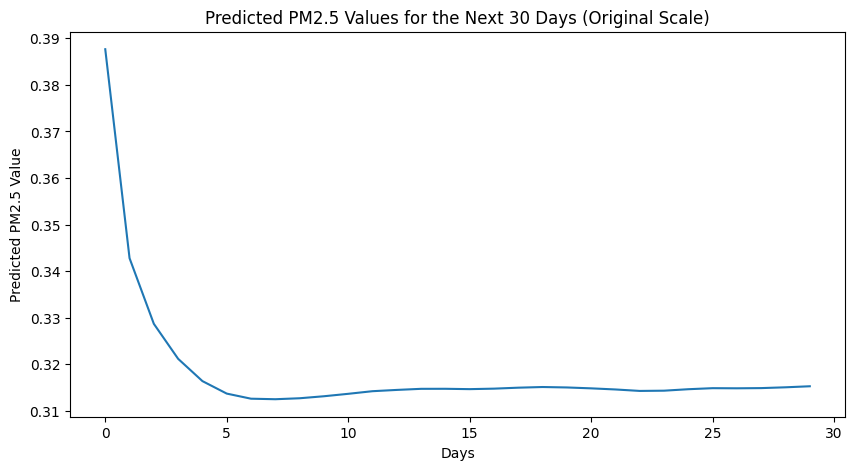

In [65]:
import matplotlib.pyplot as plt
# Convert the predictions back to the original scale
scaler.fit(data['pm25'].values.reshape(-1, 1))
next_30_days_original_scale = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(next_30_days_original_scale)
plt.title('Predicted PM2.5 Values for the Next 30 Days (Original Scale)')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()